<a href="https://colab.research.google.com/github/ninda-code/statistical-test-and-optimization/blob/main/restaurant_operation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Restaurant Operation with Optimization, Experiment and Hypothesis Testing

## Brief

**Objective** : Identifying optimum number of checkout and kitchen counters combination to maximize profit. 

**Current Situation** : A restaurant owner has the kitchen operation capacity at maximum of 7 checkout and 10 kitchen employee. Currently the store operates at allocating 3 slots for kitchen, 3 slots for check-in, and the rest being idle. 

**Complication** : The owner believes the restaurant has not reach its optimal profit potentials and wanted to explore the posibilities by changing kitchen vs check-in counter formation.

**Decission needs to be made** : How many kitchen and how many checkout counters needs to be open to maximize profit?

**Proposed Solution** : 
- Simulate potential restaurant's operation cost and revenue by trying several scenarios using different random number (`Monte Carlo`). 
- Use `hyperopt` to identify combination for maximum profit. In real aplication, it is hard to try all different combination, so, the idea is that simulating all variations computationally. Then only experiment the scenario that yield best result in simulation. 
- Design experiment by defining hypothesis and sample size
- Evaluate statistical significance of the experiment and evaluate the result. 

## Analysis

### Step 0 : Import and install required libraries

In [ ]:
! pip install scikit_posthocs
! pip install simpy
! pip install pynverse

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import scikit_posthocs as sp
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
import hyperopt
import simpy
from pynverse import inversefunc
from scipy.stats import expon, uniform, poisson

### Step 1 : Simulate restaurant operations and financials


**Assumptions and Inputs**
- Maximum capacity : counter 7, kitchen 10
- Daily people cost : kitchen-hand at USD 100, checkout-counter at USD 150
- Revenue per order : exponential 
distribution with lambda 1/15
- Customer arrival : nonhomogenous Poisson process with mean arrival function  $λ(t)=25∗sin(\frac{\pi}{10}t)$ 
- Time to make order : exponential 
distribution with lambda 15
- Time spent in the checkout : exponential 
distribution with lambda 20

*PS : adopted from Simulation's course homework*

In [ ]:
np.random.seed(42)
nsims = 100 # Try scenario at 100 steps
T = 10 # Restaurant operates 10hrs daily

input_params ={ 
  "checkout_capacity" : 7 # Maximum checkout capacity
  , "kitchen_ capacity" : 10 # Maximum kitchen capacity
  , "revenue_order": 15 # Assumed price per meal (revenue) following exponential distribution with parameter 1/15
  , "arrival": 10
  , "checkout": 20 # Assumed time spent in taking order is following exponential distribution with parameter 20
  , "kitchen":15 # Assumed time it takes to prepare a meal following exponential distribution with parameter 15
  , "max_hrs" :10 # Operating hours at 10 hours daily
  , "max_ppl_inline" : 5 # Maximum person in the checkout line, otherwise rejected and counted as opportunity cost
  , "max_ppl_waiting" : 10 # Maximum person in the waiting for food line
  , "cost_employee_co" :150 # Salary of checkout staff
  , "cost_employee_kitchen" :100 # Salary of kitchen-hand staff
  , "cost_opportunity" : 30 # Estimated opportunity cost for every rejected customer for when the line is full
}

**Output**

In [ ]:
output = { 
  "arrivals":[] # Incoming customer
  , "customers":[] # Accepted customers
  , "leavers" :[] # Rejected customers (loss of opportunity)
  , "departures":[] # Customer departure time
  , "checkout_queue":[] # Ccheckout queue
  , "kitchen_queue":[] # Kitchen queue
  , "order_price": [] # Revenue per order
  }

**Simulations functions**

In [ ]:
def Lmbda(t): # Arrival rate function
    return - 250/np.pi * np.cos((np.pi * t)/(10))+ 250/np.pi

def poisson_process(lmbda, T): 
    N = poisson.rvs(lmbda*T) 
    S = uniform.rvs(size=N) * T 
    return np.sort(S) 

def interarrivals_times(Lmbda, T):
    LmbdaT = Lmbda(T)
    inv = inversefunc(Lmbda, domain=[0,10],open_domain=[True, True])
    s = poisson_process(1, LmbdaT)
    t = inv(s)
    X = t.copy()
    X[1:] = np.diff(t)
    for dt in X:
        yield dt

# Queueing system
def arrival(env, dts, checkout, kitchen, total_arrivals, checkout_times, kitchen_times, revenue_order, left):
    i = 0
    while True:
        try:
            dt = next(dts)
        except:
            total_cust = len(output["arrivals"]) + len(output["leavers"])
            total_arrivals.append(i)
            left.append(i - len(revenue_order))       
            break
        yield env.timeout(dt)

        if len(checkout.queue) <= input_params["max_ppl_inline"] and len(kitchen.queue) <= input_params["max_ppl_waiting"]:
            pi = expon.rvs(scale=input_params["revenue_order"])
            revenue_order.append(pi)
            output['arrivals'].append(env.now)
            output['order_price'].append(pi)
            output['checkout_queue'].append(len(checkout.queue))
            output['kitchen_queue'].append(len(kitchen.queue))
            output['customers'].append(i)
            env.process(service(env, dts, checkout, kitchen,total_arrivals, checkout_times, kitchen_times, revenue_order))
        else:
            output['leavers'].append(i)
            pass
        i += 1

def service(env, dts, checkout, kitchen, total_arrivals, checkout_times, kitchen_times, revenue_order):
    rqt1 = checkout.request()
    yield rqt1
    dt1 = expon.rvs(scale=1/input_params["checkout"])
    yield env.timeout(dt1)
    checkout.release(rqt1)
    checkout_times.append(dt1)

    rqt2 = kitchen.request()
    yield rqt2
    dt2 = expon.rvs(scale=1/input_params["kitchen"])
    yield env.timeout(dt2)
    kitchen.release(rqt2)
    kitchen_times.append(dt2)
    output['departures'].append(env.now)

def simulate(num_checkout, num_kitchen):
    total_arrivals = []
    checkout_times = []
    kitchen_times = []
    revenue_order = []
    left = []
    
    # Initiate environment
    env = simpy.Environment()

    # Initiate resources and arrivals
    dts = interarrivals_times(Lmbda,T)
    checkout = simpy.Resource(env, capacity=num_checkout)
    kitchen = simpy.Resource(env, capacity=num_kitchen)

    # Initiate process
    env.process(arrival(env, dts, checkout, kitchen, total_arrivals, checkout_times, kitchen_times, revenue_order, left))
    env.run()

    # Calculate metrics
    cost = input_params["cost_employee_co"]*num_checkout + input_params["cost_employee_kitchen"]*num_kitchen + input_params["cost_opportunity"]*left[0]
    revenue = np.sum(revenue_order)
    profit = revenue - cost
    cost_margin = cost/revenue


    return profit, revenue, cost, cost_margin, np.mean(total_arrivals), np.mean(checkout_times),np.mean(kitchen_times),np.mean(revenue_order), output


### Step 2 : Simulate data for current state
For sanity check, see if the simulation outcomes mimic the actual data. For this particular made-up analysis, let's assume that it does mimic the actual financial performance of the restaurant. 

In [ ]:
np.random.seed(42)
control_dummy = [simulate(3,3) for i in range(0, 1000)] # Simulate 1000 times to see the distribution

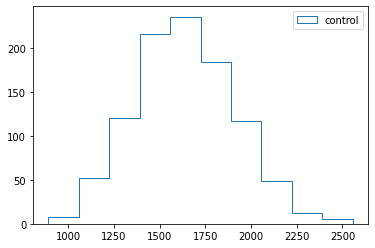

Simulated average daily profit : 1,640.88


In [ ]:
# Profit simulation outcome

c_profit_dummy = [i[0] for i in control_dummy]
plt.hist(c_profit_dummy, label = "control", histtype = "step", bins=10)
plt.legend()
plt.show()
print("Simulated average daily profit : {:,.2f}".format(np.mean(c_profit_dummy)))

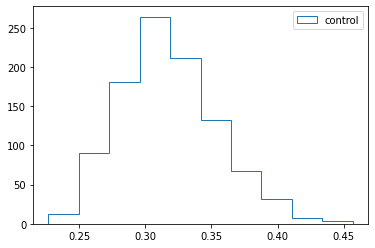

Simulated average daily cost margin : 0.32


In [ ]:
# Cost margin simulation outcome

c_costmargin_dummy = [i[3] for i in control_dummy]
plt.hist(c_costmargin_dummy, label = "control", histtype = "step", bins=10)
plt.legend()
plt.show()
print("Simulated average daily cost margin : {:,.2f}".format(np.mean(c_costmargin_dummy)))

### Step 3 : Use optimization solver to identify configuration to maximize profit

In [ ]:
def objective(params):
    np.random.seed(42)
    n = 100
    x = params[0]
    y = params[1]
    profit = [simulate(params[0],params[1])[0] for i in range(n)]
    return -1*np.mean(profit)

trials = hyperopt.Trials()
best = hyperopt.fmin(fn=objective,
    space = [hyperopt.hp.quniform("num_checkout",1,7,1), hyperopt.hp.quniform("num_kitchen",1,10,1)],
    algo = hyperopt.tpe.suggest,
    max_evals = 50,
    trials = trials)
print(best)

100%|██████████| 50/50 [06:19<00:00,  7.60s/it, best loss: -1840.2112581033434]
{'num_checkout': 2.0, 'num_kitchen': 2.0}


## Experiment Design

### Hypothesis

**Tested scenarios**
- Control : 3 kitchen and 3 checkout
- Treatment 1 : 2 kitchen and 2 checkout
- Treatment 2 : 4 kitchen and 4 checkout

**H0 : control = treatment 1 = treatment 2** <br />
The profit of all groups are the same and if there's any difference, it is all still statistically insignificance

**H1 : At least one of them are different**

### Assumptions for experiment parameters

- **Effect Size** : It is assumed that at least the experiment needs to show **5%** uplift on the profit to ensure that the whole changes and configuration make sense from business perspective
- **Alpha/ Significance level** : Let's use common convention of 0.05
- **Power** : Due to an alpha inflation, to increase the probability that the test correctly rejects the Null Hypothesis if the Alternative Hypothesis is true we set this at 80%
- **Calculate the required sample size**
Since later we going to use F-test ANOVA, we set the sampel size calculator respective of the test. Hence, we use `FTestAnovaPower` for the analysis. 

In [ ]:
effect_size = sm.stats.proportion_effectsize(0.5, 0.55) 
# proportion formula : 2 * (arcsin(sqrt(prop1)) - arcsin(sqrt(prop2)))

significance_level = 0.05
power = 0.8
# is one minus the probability of a type II error. Power is the probability that the test correctly rejects the Null Hypothesis if the Alternative Hypothesis is true.

analysis =  sm.stats.FTestAnovaPower()
nobs = analysis.solve_power(effect_size=effect_size, alpha=significance_level, power=power, k_groups=3)

print("Required sample-size for each group is : {:,.0f}".format(math.ceil(nobs)))

Required sample-size for each group is : 964


## Simulate the data for experiment result

In [ ]:
np.random.seed(42)
data_control = [simulate(3,3) for i in range(0, 1000)]
data_treatment_1 = [simulate(2,2) for i in range(0, 1000)]
data_treatment_2 = [simulate(4,4) for i in range(0, 1000)]

### Profit

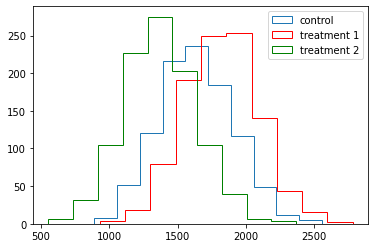

In [ ]:
c_profit = [i[0] for i in data_control]
t1_profit = [i[0] for i in data_treatment_1]
t2_profit = [i[0] for i in data_treatment_2]

plt.hist(c_profit, label = "control", histtype = "step", bins=10)
plt.hist(t1_profit, label = "treatment 1", histtype = "step", bins=10, color = "r")
plt.hist(t2_profit, label = "treatment 2", histtype = "step", bins=10, color = "g")
plt.legend()
plt.show()

### Cost Margin

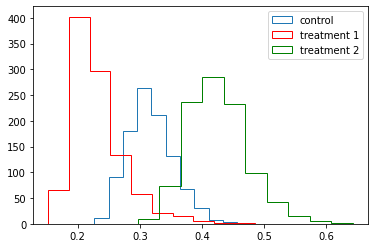

In [ ]:
c_costmargin = [i[3] for i in data_control]
t1_costmargin = [i[3] for i in data_treatment_1]
t2_costmargin = [i[3] for i in data_treatment_2]

plt.hist(c_costmargin, label = "control", histtype = "step", bins=10)
plt.hist(t1_costmargin, label = "treatment 1", histtype = "step", bins=10, color = "r")
plt.hist(t2_costmargin, label = "treatment 2", histtype = "step", bins=10, color = "g")
plt.legend()
plt.show()

## Evaluate hypotesis testing outcome
#### Test for Profit significance test : ANOVA (parametric groups)
See if the difference in the of the profit is statistically significance. Since we have 3 groups, we'll need to check first to see if there is "ANY" differences within groups. Then if it does, we'll check the p-value of each pair of the groups to identify where the significance lies.

In [ ]:
control = c_profit
treatment_1 = t1_profit
treatment_2 = t2_profit

alpha = 0.05

**Check if groups are following normal distribution and sharing same variance**

Use Shapiro and Levene tests with alpha of 0.05

In [ ]:
# Test if the experiment result is significant (hypothesis testing)

def is_normal(data):
  pval = stats.shapiro(data)[1]
  print("p-values : {:.4f}".format(pval))
  print("Reject null hypothesis -> Samples are not normally distributed") if pval < alpha else print("Fail to reject null hypothesis -> Samples are normally distributed")

is_normal(control)
is_normal(treatment_1)
is_normal(treatment_2)

pval = stats.levene(control, treatment_1, treatment_2)[1]
print("p-values : {:.4f}".format(pval))
print("Reject null hypothesis -> Variances of the sample are different") if pval < alpha else print("Fail to reject null hypothesis -> Variances of the sample are the same")

p-values : 0.0996
Fail to reject null hypothesis -> Samples are normally distributed
p-values : 0.4812
Fail to reject null hypothesis -> Samples are normally distributed
p-values : 0.1325
Fail to reject null hypothesis -> Samples are normally distributed
p-values : 0.3754
Fail to reject null hypothesis -> Variances of the sample are the same


**Check if there is any difference within group** <br/>
Use F-test 

In [ ]:
# Check statistical significance of the experiments
F, pval = stats.f_oneway(control, treatment_1, treatment_2)
print("p-values : {:.4f}".format(pval))
print("Reject null hypothesis -> At least one of the mean of the samples is different") if pval < alpha else print("Fail to reject null hypothesis -> The mean of the samples are all the same")

p-values : 0.0000
Reject null hypothesis -> At least one of the mean of the samples is different


In [ ]:
# Check which pair is differ
# Use Bonferroni to damplen alpha-inflation

df_posthoc = sp.posthoc_ttest([control, treatment_1, treatment_2], equal_var = True, p_adjust = "bonferroni")
df_posthoc.columns = ["control", "treatment_1", "treatment_2"]
df_posthoc.index = ["control", "treatment_1", "treatment_2"]
df_posthoc.style.applymap(lambda x: "background-color:yellow" if x<0.05 else "background-color: white")

,control,treatment_1,treatment_2
control,1.000000,0.000000,0.000000
treatment_1,0.000000,1.000000,0.000000
treatment_2,0.000000,0.000000,1.000000


In [ ]:
c_mean = np.mean(control)
t1_mean = np.mean(treatment_1)
t2_mean = np.mean(treatment_2)
print(c_mean)
print((t1_mean/c_mean)-1)
print((t2_mean/c_mean)-1)

1640.8824067257506
0.11209714424567352
-0.16319097759069223


### Test for Cost Margin significance test : Kruskall (non-parametric groups)

In [ ]:
# For cost margin
control = c_costmargin
treatment_1 = t1_costmargin
treatment_2 = t2_costmargin


In [ ]:
is_normal(control)
is_normal(treatment_1)
is_normal(treatment_2)

pval = stats.levene(control, treatment_1, treatment_2)[1]
print("p-values : {:.4f}".format(pval))
print("Reject null hypothesis -> Variances of the sample are different") if pval < alpha else print("Fail to reject null hypothesis -> Variances of the sample are the same")

p-values : 0.0000
Reject null hypothesis -> Samples are not normally distributed
p-values : 0.0000
Reject null hypothesis -> Samples are not normally distributed
p-values : 0.0000
Reject null hypothesis -> Samples are not normally distributed
p-values : 0.0000
Reject null hypothesis -> Variances of the sample are different


In [ ]:
# Check statistical significance of the experiments

F, pval = stats.kruskal(control, treatment_1, treatment_2)
print("p-values : {:.4f}".format(pval))
print("Reject null hypothesis -> At least one of the mean of the samples is different") if pval < alpha else print("Fail to reject null hypothesis -> The mean of the samples are all the same")

p-values : 0.0000
Reject null hypothesis -> At least one of the mean of the samples is different


In [ ]:
# Check which pair is differ
# Use Bonferroni to damplen alpha-inflation

df_posthoc = sp.posthoc_mannwhitney([control, treatment_1, treatment_2], p_adjust = "bonferroni")
df_posthoc.columns = ["control", "treatment_1", "treatment_2"]
df_posthoc.index = ["control", "treatment_1", "treatment_2"]
df_posthoc.style.applymap(lambda x: "background-color:yellow" if x<0.05 else "background-color: white")

,control,treatment_1,treatment_2
control,1.000000,0.000000,0.000000
treatment_1,0.000000,1.000000,0.000000
treatment_2,0.000000,0.000000,1.000000


In [ ]:
c_mean = np.mean(control)
t1_mean = np.mean(treatment_1)
t2_mean = np.mean(treatment_2)
print(c_mean)
print((t1_mean/c_mean)-1)
print((t2_mean/c_mean)-1)

0.31810523939447594
-0.2668002733805491
0.3411636001785068


## Conclusion

- It is found that out of maximum capacity of **7** checkouts and **10** kitchens, it is most optimum for the profit to have **2** checkouts and **2** kitchens. 

- There are 3 configurations being experimented with all treatments have statitical significance with p-value 0.00 when compared with control. 

- The experiment shows that the optimal configuration increases profit by **~11%** from initial value of **1,640** to **1,820**

## Reccomendation

**Reduce kitchen and checkout counter into 2 and 2 configuration with the expected profit increase at ~10%**